In [131]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import mdtraj as md
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from functools import reduce, partial
import scipy
from typing import Tuple
from importlib import reload
from cycler import cycler
from itertools import chain
# source modules and classes being developed 
from writhe_tools.writhe import (Writhe,
                                 get_segments)


from writhe_tools.plots import (
                                proj2d,
                                fes2d,
                                get_color_list,
                                box_plot,
                                build_matrix_boxplot_grid,
                                lineplot1D)

from writhe_tools.tcca import CCA, tCCA

from matplotlib.lines import Line2D

from writhe_tools.stats import Kmeans, rotate_points, acf, pmf


from writhe_tools.md_tools import (ResidueDistances,
                                   get_residues,
                                   calc_sa,
                                   traj_slice,
                                   load_traj,
                                   plot_distance_matrix,
                                   residue_distances,                                 
                                   to_contacts
                                    )


from writhe_tools.utils import (lsdir,
                                group_by,
                                reindex_list,
                                contiguous_bool,
                                to_numpy,
                                num_str,
                                load_dict,
                                save_dict,
                                product
                                )


from typing import Dict, List, Tuple


import warnings
warnings.filterwarnings("ignore")



fes2d_args = dict(
      cmap="coolwarm",
      bins=55,
      n_contours=8,
      contour_lines=True,
      alpha_lines=0.35,
      alpha_contours=0.6,
      mask=False,
      scatter=True,
      scatter_alpha = .15,
      scatter_size=.05,
      scatter_stride=50,
      scatter_max=.35,
      scatter_min=.15,
      scatter_cmap="coolwarm",
      hide_ax=False,
      extend_border=0.1,
    )



def fill_1d(x, values, indices):
    x[indices] = values
    return x

def fill(x, index, val):
    x[:, index] = val
    return x

def prod(vectors, sum_=False):
    if sum_:
        vectors = [v.sum(axis=-1) for v in vectors]
    return reduce(np.multiply, vectors)

split = partial(np.array_split, indices_or_sections=2, axis=-1) 

ternary_bool = lambda distances : prod([to_contacts(i, 1).any(1) for i in split(distances)])

isin_index = lambda x, y : np.where(np.isin(x, y))[0]




def bootstrap(data: np.ndarray,
              confidence_level: float = 0.68,
              n_resamples: int = 500,
              lower_upper: bool = False,
              method: str = "percentile") -> Tuple[float, float]:
    """
    Bootstrap binary data to get the mean and an intentionally wide error estimate.

    Parameters:
        data: binary array of 0s and 1s
        confidence_level: typically 0.99 for wider intervals
        n_resamples: lower values increase variability (default 500)
        method: use 'percentile' to produce wider CIs

    Returns:
        mean: estimated mean of the binary array
        error: half-width of the confidence interval
    """

    res = scipy.stats.bootstrap((data,), statistic=np.mean,
                    confidence_level=confidence_level,
                    n_resamples=n_resamples,
                    method=method,
                    random_state=0)

    mean = np.mean(data) if data.ndim == 1 else data.mean(0)
    error = [res.confidence_interval.low, res.confidence_interval.high] if lower_upper\
            else (res.confidence_interval.high - res.confidence_interval.low) / 2
    if data.ndim > 1:error = np.stack(error)
    
    return mean, error


def group_contiguous_indices(indices):
    """
    Group sequential (contiguous) integer indices into runs.
    Parameters
    ----------
    indices : array-like of int
        Unordered collection of integer indices (e.g., [6, 1, 2, 3, 10]).
    Returns
    -------
    groups : list of np.ndarray
        Each element is a 1D NumPy array of contiguous integers, sorted ascending.
        Singletons (isolated indices) are included as length-1 arrays.
    Example
    -------
    >>> group_contiguous_indices([6, 1, 2, 3, 10])
    [array([1, 2, 3]), array([6]), array([10])]
    """
    if len(indices) == 0:
        return []
    idx = np.sort(np.unique(np.asarray(indices, dtype=int)))
    # Find boundaries where difference > 1 (i.e., gap)
    gaps = np.where(np.diff(idx) > 1)[0]
    # Split at those points (+1 because diff shrinks by 1)
    split_points = np.split(idx, gaps + 1)
    # Filter out empty splits (shouldn't happen but safe)
    groups = [np.array(run, dtype=int) for run in split_points if len(run) > 0]
    return groups


import numpy as np
import warnings

def block_error_disjoint(snippets=None,
                        data=None,
                        indices=None,
                        rowvar=0,
                        ddof=None, 
                        override_tol=None,
                        override_max_levels=None,
                        verbose=False):
    """
    Blocking analysis similar to pyblock.reblock style, extended to disjoint snippets.
    Defaults to reblocking until minimal size, then uses a Wolff/Lee criterion
    (as in pyblock.find_optimal_block) to pick final block index.
    
    Parameters
    ----------
    data : Array of possibly multivariate data to estimate D errors from. 
         1D or 2D. If 1D, shape (N,). If 2D, shape (N, D).
    indices : Int Array of the trajectory indices of each
    rowvar : int (0 or 1)
        Determines orientation of variables in multivariate data (matching pyblock API).
    ddof : int or None
        Degrees of freedom for variance normalization (like numpy var).
    override_tol : float or None
        If provided, use a “tolerance-based plateau check” as fallback (not default).
    override_max_levels : int or None
        If provided, restrict how many blocking levels per snippet.
    verbose : bool
        Print diagnostics and warnings.

    Returns
    -------
    se_mean : np.ndarray, shape (D,)
    var_mean : np.ndarray, shape (D,)
    details : list of dict (one per snippet) with keys:
        'block_stats': list of dicts per block with entries
            { 'level', 'ndata', 'mean', 'cov', 'std_err', 'std_err_err' },
        'optimal_block' : chosen block level
    """
    # Helper to reblock a single snippet
    def reblock_single(data):
        """
        Reblock one snippet’s data until minimal length, return list of stats.
        """
        # data: shape (N, D)
        D = data.shape[1]
        stats = []
        x = data.copy()
        level = 0
        n = len(x)
        while n >= 2:
            mean = np.mean(x, axis=0)
            # covariance matrix
            cov = np.cov(x, rowvar=False, ddof=ddof)
            # standard error of mean: sqrt(var / N) for each variable
            var = np.diag(cov)
            std_err = np.sqrt(var / n)
            # estimate error in std_err: roughly std_err / sqrt(2n) (as in pyblock) — approximate
            std_err_err = std_err / np.sqrt(2 * n)
            stats.append({
                'level': level,
                'ndata': n,
                'mean': mean,
                'cov': cov,
                'std_err': std_err,
                'std_err_err': std_err_err
            })
            # block: average pairs
            if n % 2 != 0:
                x = x[:-1, :]
            x = 0.5 * (x[0::2, :] + x[1::2, :])
            level += 1
            n = len(x)
        return stats

    # Process each snippet
    if snippets is None:
        assert data is not None and indices is not None, ("Must provide either a nested list of"
                                                          "continuous snippets of time series observables"
                                                          "Or the full data and a set of indices giving the"
                                                          "time step of each row in data (N,D")
        snippet_indices = group_contiguous_indices(indices)
        snippets = [data[i] for i in snippet_indices]
    snippet_details = []
    total_N = sum(len(s) for s in snippets)
    D = None

    for idx, s in enumerate(snippets):
        arr = np.atleast_2d(s)
        if arr.shape[0] < arr.shape[1]:
            # treat shape (D, N) orientation
            arr = arr.T
        N, d = arr.shape
        if D is None:
            D = d
        elif d != D:
            raise ValueError("All snippets must have same number of observables")

        stats = reblock_single(arr)
        # Decide optimal block (like pyblock.find_optimal_block)
        # Implement simple version: choose the block after which std_err begins to flatten (Wolff/Lee)
        opt = None
        for b in range(1, len(stats)):
            prev = stats[b - 1]['std_err']
            curr = stats[b]['std_err']
            # condition: B^3 >= 2 * n * (SE(B)/SE(0))^4
            B = 2 ** b
            n0 = stats[0]['ndata']
            ratio = curr / stats[0]['std_err']
            if B**3 >= 2 * n0 * (ratio ** 4):
                opt = b
                break
        if opt is None:
            opt = len(stats) - 1
            if verbose:
                warnings.warn(f"Snippet {idx}: optimal block not found; using last level {opt}")
        snippet_details.append({'block_stats': stats, 'optimal_block': opt})

    # Combine across snippets (no cross-observable covariance)
    weighted_var = np.zeros(D)
    for idx, det in enumerate(snippet_details):
        stats = det['block_stats']
        opt = det['optimal_block']
        var_vec = np.diag(stats[opt]['cov']) / stats[opt]['ndata']
        n = snippets[idx].shape[0]
        weighted_var += var_vec * (n**2)
    weighted_var /= total_N**2
    se_mean = np.sqrt(weighted_var)
    return np.concatenate(), se_mean, #weighted_var, snippet_details


from pyblock.blocking import reblock, find_optimal_block
from collections import Counter

def block_error(x: np.ndarray, lower_upper: bool = False):
    """
    x : (N, d) numpy array with d features and N measurements
    """
    n = x.shape[0]
    blocks = reblock(x.T)
    optimal_indices = np.asarray(find_optimal_block(n, blocks))
    isnan = np.isnan(optimal_indices)
    #mode = Counter(optimal_indices[~isnan].astype(int)).most_common()[0][0]
    optimal_indices[isnan] = -1 # biggest block
    optimal_indices=optimal_indices.astype(int)
    #op
    #print(optimal_indices[0])
    if x.ndim == 1:
        return lu_from_error(x.mean(), blocks[optimal_indices[0]].std_err.item()) if lower_upper else\
                (x.mean(), blocks[optimal_indices[0]].std_err.item())
    else:
        return lu_from_error(x.mean(0), np.asarray([blocks[i].std_err[j] for j, i in enumerate(optimal_indices.astype(int))]))\
                if lower_upper else (x.mean(0), np.asarray([blocks[i].std_err[j] for j, i in enumerate(optimal_indices.astype(int))]))

def lu_from_error(mean, error):
    if all(isinstance(i, (float, int)) for i in (mean, error)):
        mean, error = [mean], [error]
    return mean, np.array([[mu - err, mu + err] for mu, err in zip(mean, error)]).T

# convenience (hard coded to 2 monomers) function to combine stats and prop error for averages to be taken over both monomers
def monomer_aggr_stats(x, 
                       error:callable=block_error, 
                       lower_upper: bool = False, 
                       fill_bool:np.ndarray=None):
    # compue mean and error over both monomers, aggregate, fill zeros for plotting, give lower, upper errors or absolute error
    ave, err = error(x, lower_upper=False)
    ave = np.add.reduce(split(x.mean(0))) / 2
    err = np.linalg.norm(err.reshape(2, -1), axis=0) / 2
    
    if lower_upper:
        # very simple error propogation here (arguably too simple)
        err = lu_from_error(ave, err)[-1]                   
        if fill_bool is not None:
            ave = fill_1d(np.zeros(len(fill_bool)), ave, fill_bool)
            err = np.stack([fill_1d(np.zeros(len(fill_bool)), i, fill_bool) for i in err])

        return ave, err


    return (ave, err) if fill_bool is None else [fill_1d(np.zeros(len(fill_bool)), i, fill_bool) for i in [ave, err]]


#block_error(np.arange(10000), lower_upper=False)
path = "/data/r1r2"
epi_dir = f"{path}/epi002"
apo_dir = f"{path}/apo"
cam_dir = f"{path}/cam1"
paths = [apo_dir, epi_dir, cam_dir]
labels = ['APO', 'EPI-002', '1aa']

protein_files = ['/data/r1r2/apo/protein.100us.dcd',
                 '/data/r1r2/epi002/protein.100us.dcd',
                 '/data/r1r2/cam1/protein.85us.dcd']


ligand_files = [lsdir(i, keyword=['dcd', 'ligand'], exclude=['wrap'], match=all)[0] for i in paths[1:]]
protein_pdb = '/data/r1r2/epi002/R2_dimer.pdb'
ligand_pdbs = [
               '/data/r1r2/epi002/R2_dimer.epi002.rename.pdb',
               '/data/r1r2/cam1/protein.ligand.pdb',
               ]
helix_pdb = '/data/r1r2/monomer_r1r2_helix.pdb'

trunc = .3
pre_trunc = .3
state_width = .8
state_font_scale = 1.5
codes = np.array(list(md.load(protein_pdb).top.to_fasta()[0]))[:24]


In [181]:
dimers = [np.load(i) for i in reindex_list(lsdir('./medium_events', exclude='lengths'), [1,2,0])]
average_dimer=[bootstrap(.24 * np.fromiter(map(len, contiguous_bool(bools=i)), float), lower_upper=False) for i in dimers] # scale by physical time

In [176]:
average_dimer

[(16.946901599349417, [14.417742694497154, 19.412243534833287]),
 (28.413188133683807, [22.215276004506194, 34.42737363875328]),
 (91.85138576779025, [54.4994277153558, 124.20638202247194])]

In [158]:
dimers = [np.load(i) for i in reindex_list(lsdir('./events', exclude='lengths'), [1,2,0])]
[bootstrap(.24 * np.fromiter(map(len, contiguous_bool(bools=i)), float)) for i in dimers] # scale by physical time

[(8.340750218086653, 1.0917550450712432),
 (7.33685908319185, 0.8425584040747025),
 (10.01085882352941, 1.8243656470588236)]

In [197]:
dimers = [np.load(i) for i in reindex_list(lsdir('./medium_events', exclude='lengths'), [1,2,0])]
average_dimer=[bootstrap(.24 * np.fromiter(map(len, contiguous_bool(bools=i)), float), lower_upper=False, n_resamples=50) for i in dimers] 

In [198]:
average_dimer

[(16.946901599349417, 2.034186391976146),
 (28.413188133683807, 4.90199684566279),
 (91.85138576779025, 31.62932134831462)]

In [219]:
dimers = [np.load(i) for i in reindex_list(lsdir('./long_events', exclude='lengths'), [1,2,0])]
average_dimer = [bootstrap(.24 * np.fromiter(map(len, contiguous_bool(bools=i)), float), lower_upper=False) for i in dimers] 

<Axes: title={'center': 'Mean Dimer Lifetimes'}>

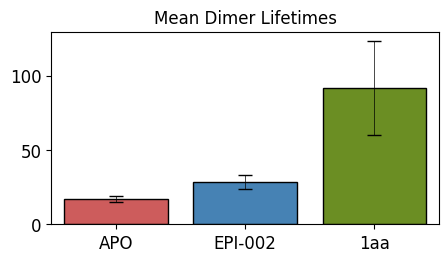

In [199]:
box_plot(np.fromiter((i[0] for i in average_dimer), float),
         errors=np.array([i[1] for i in average_dimer]).T,
         error_capsize=5,
         error_linewidth=.5,
         error_capthick=1,
         error_color='black',
         #cmap="coolwarm",
         color_list=['indianred','steelblue', 'olivedrab'],
         alpha=1, 
         font_scale=2, 
         labels=labels,
         title = 'Mean Dimer Lifetimes',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         width=0.8,figsize=(5, 2.5))


In [180]:
average_dimer

[(16.946901599349417, [14.417742694497154, 19.412243534833287]),
 (28.413188133683807, [22.215276004506194, 34.42737363875328]),
 (91.85138576779025, [54.4994277153558, 124.20638202247194])]

In [160]:

def acf(x):
    """
    Computes the autocorrelation function (ACF) of a 1D time series using FFT.

    Parameters:
    - x (np.ndarray): Input 1D signal.

    Returns:
    - acf (np.ndarray): The autocorrelation function.
    """
    N = len(x)
    # Normalize the input (subtract mean, if needed)
    x = x - np.mean(x)
    # Compute FFT of the signal
    # Compute Inverse FFT of the power spectrum
    # Normalize by variance (pearson correlation)
    var = np.var(x)
    result = np.fft.ifft(np.abs(np.fft.fft(x, n=2*N))**2).real[:N] / N
    
    return result / (var if var != 0 else result.max())


def block_acf(binary, n_split=5, trunc=3000):
    acfs = np.stack([acf(i)[:trunc] for i in np.array_split(binary, n_split)])
    mu = acfs.mean(0)
    sd = lu_from_error(mu, acfs.std(0) / (n_split)**(.5))[-1]
    return mu, sd
    
def acf_direct(x, max_lag=4000, atol=1e-12, fillna=0.0):
    """
    Robust normalized autocorrelation (Pearson-style) of a 1D signal,
    computed up to a specified maximum lag, without FFT.

    Edge-case protocol:
      • Constant / zero-variance block → ACF = all ones
      • Empty or NaN-only input → all fillna (default zeros)

    Parameters
    ----------
    x : np.ndarray
        Input 1D array.
    max_lag : int or None
        Maximum lag to compute. If None, uses len(x).
    atol : float
        Absolute tolerance below which variance is considered zero.
    fillna : float
        Value to fill when input is empty or NaN-only.

    Returns
    -------
    acf : np.ndarray
        Autocorrelation values from lag 0 to max_lag-1.
    """
    x = np.asarray(x, dtype=float)
    N = len(x)

    if N == 0 or np.all(np.isnan(x)):
        # No data: return zeros or fillna
        return np.full(1 if max_lag is None else max_lag, fillna)

    x = x - np.nanmean(x)
    var = np.nanvar(x)

    if max_lag is None or max_lag > N:
        max_lag = N

    # Constant series → ACF = all ones
    if var < atol:
        return np.ones(max_lag, dtype=float)

    acf = np.empty(max_lag, dtype=float)
    for lag in range(max_lag):
        valid = N - lag
        acf[lag] = np.dot(x[:valid], x[lag:]) / (valid * var)

    return acf


def block_acf_direct(binary, n_split=2, trunc=3000):
    acfs = np.stack([acf_direct(i, max_lag=trunc) for i in np.array_split(binary, n_split)])
    mu = acfs.mean(0)
    sd = lu_from_error(mu, acfs.std(0) / (n_split)**(.5))[-1]
    return mu, sd



    

In [263]:
acfs = [block_acf(i, 1, 8000) for i in dimers]

In [288]:
import numpy as np
from scipy.optimize import curve_fit
from scipy import stats

def multi_exp(x, *params, pcov=None, return_error=False,
              prediction_variance=False, s2=None):
    """
    Sum of exponentials with optional covariance-based uncertainty propagation.

    Parameters
    ----------
    x : array_like
        Independent variable(s).
    *params : float
        Parameters [a1, tau1, a2, tau2, ...].
    pcov : (m, m) array, optional
        Covariance matrix of the fitted parameters (from curve_fit).
        Must already include the residual variance scaling (as curve_fit does).
    return_error : bool, default=False
        If True and pcov is given, returns (y, sigma_y).
    prediction_variance : bool, default=False
        If True, include the residual variance term (s2) when computing
        propagated uncertainty (i.e., return the *prediction* variance).
        If False, return the *mean-curve* (confidence) variance only.
    s2 : float, optional
        Residual variance. Required if prediction_variance=True and
        you want to include noise explicitly. If None and prediction_variance=True,
        s2 is estimated as the average diagonal of pcov scaling (safe fallback).

    Returns
    -------
    y : ndarray
        Model values at x.
    sigma_y : ndarray, optional
        1σ propagated uncertainty at each x (confidence or prediction band).
    """
    x = np.asarray(x, dtype=float)
    params = np.asarray(params, dtype=float)
    n = len(params) // 2
    a = params[0::2]
    tau = params[1::2]

    # Model evaluation
    exp_terms = np.exp(-x[:, None] / tau[None, :])      # (N, n)
    y = np.sum(a[None, :] * exp_terms, axis=1)          # (N,)

    if not (return_error and pcov is not None):
        return y

    # Analytical Jacobian: shape (N, 2n)
    N = x.size
    J = np.empty((N, 2*n), dtype=float)

    # ∂y/∂a_i = e^{-x/τ_i}
    J[:, 0::2] = exp_terms

    # ∂y/∂τ_i = a_i * (x/τ_i^2) * e^{-x/τ_i}
    x_over_tau2 = x[:, None] / (tau[None, :]**2)
    J[:, 1::2] = (a[None, :] * x_over_tau2) * exp_terms

    # Propagate covariance: Var(y) = J Cov J^T
    var_y = np.einsum("ij,jk,ik->i", J, pcov, J, optimize=True)

    # Optional: include residual variance for prediction interval
    if prediction_variance:
        if s2 is None:
            # Safe fallback: use scalar estimate from pcov trace / param count
            s2 = np.mean(np.diag(pcov)) / np.mean(np.diag((pcov / np.diag(pcov))**0))
            # Simpler fallback if the above ever fails numerically:
            s2 = np.mean(np.diag(pcov)) if not np.isfinite(s2) else s2
        var_y += s2

    sigma_y = np.sqrt(np.maximum(var_y, 0.0))
    return y, sigma_y



def fit_multi_exp(x, y, n_exp=2, p0=None, bounds=(0, np.inf), alpha=0.05, verbose=True):
    """
    Fit n_exp exponentials to data (x, y) and print a detailed summary.

    Returns
    -------
    results : dict of all fitted parameters, errors, and diagnostics.
    """
    x, y = np.asarray(x), np.asarray(y)

    # Crude initial guess if none provided
    if p0 is None:
        A_guess = np.linspace(y.max(), y.max() / n_exp, n_exp)
        T_guess = np.linspace((x.max() - x.min()) / (2*n_exp), x.max()/n_exp, n_exp)
        p0 = np.ravel(np.column_stack([A_guess, T_guess]))

    popt, pcov = curve_fit(lambda x, *p: multi_exp(x, *p), x, y, p0=p0, bounds=bounds)

    # Model, residuals, and stats
    y_fit = multi_exp(x, *popt)
    residuals = y - y_fit
    n, p = len(y), len(popt)
    dof = max(1, n - p)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
    rmse = np.sqrt(ss_res / dof)
    perr = np.sqrt(np.diag(pcov))

    # Confidence intervals
    t_crit = stats.t.ppf(1 - alpha/2, dof)
    ci_lower = popt - t_crit * perr
    ci_upper = popt + t_crit * perr

    # Relative (%) errors
    rel_err = np.abs(100 * perr / popt)

    # --- Pretty summary printout ---
    if verbose:
        print("="*78)
        print(f"EXPONENTIAL FIT SUMMARY  (n_exp = {n_exp})")
        print("="*78)
        print(f"Data points (n): {n:<8d}  Degrees of freedom: {dof:<8d}")
        print(f"Residual SS: {ss_res:.6g}    Total SS: {ss_tot:.6g}")
        print(f"R² = {r2:.6f}    RMSE = {rmse:.6g}\n")

        print(f"{'Parameter':<8} {'Value':>14} {'±1σ':>14} {'RelErr %':>10} "
              f"{'95% CI lower':>16} {'95% CI upper':>16}")
        print("-"*78)

        for i in range(n_exp):
            ai, taui = 2*i, 2*i + 1
            print(f"a{i+1:<2} {'':<3}{popt[ai]:>14.6g} {perr[ai]:>14.6g} "
                  f"{rel_err[ai]:>10.3f} {ci_lower[ai]:>16.6g} {ci_upper[ai]:>16.6g}")
            print(f"τ{i+1:<2} {'':<3}{popt[taui]:>14.6g} {perr[taui]:>14.6g} "
                  f"{rel_err[taui]:>10.3f} {ci_lower[taui]:>16.6g} {ci_upper[taui]:>16.6g}")
            print("-"*78)
        print("\n")

    return {
        "popt": popt,
        "pcov": pcov,
        "perr": perr,
        "rel_err": rel_err,
        "ci": (ci_lower, ci_upper),
        "residuals": residuals,
        "ss_res": ss_res,
        "ss_tot": ss_tot,
        "r2": r2,
        "rmse": rmse,
        "dof": dof,
        "n": n
    }

fits = [fit_multi_exp(np.arange(8000) * 0.24, i[0][:8000]) for i in acfs]

EXPONENTIAL FIT SUMMARY  (n_exp = 2)
Data points (n): 8000      Degrees of freedom: 7996    
Residual SS: 1.19028    Total SS: 185.522
R² = 0.993584    RMSE = 0.0122008

Parameter          Value            ±1σ   RelErr %     95% CI lower     95% CI upper
------------------------------------------------------------------------------
a1           0.419164     0.00170284      0.406         0.415826         0.422502
τ1            56.0496       0.447736      0.799          55.1719          56.9273
------------------------------------------------------------------------------
a2           0.458033     0.00107505      0.235         0.455925          0.46014
τ2            588.643        1.38895      0.236           585.92          591.366
------------------------------------------------------------------------------


EXPONENTIAL FIT SUMMARY  (n_exp = 2)
Data points (n): 8000      Degrees of freedom: 7996    
Residual SS: 2.62305    Total SS: 116.885
R² = 0.977559    RMSE = 0.018112

Parameter

(0.0, 1500.0)

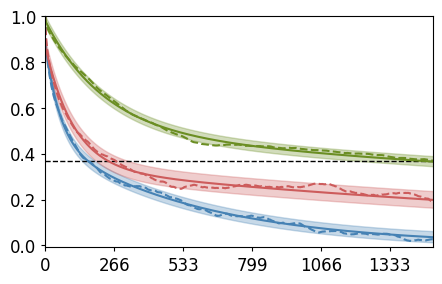

In [290]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

ax.axhline(y=1/np.exp(1),
                linestyle='--',
                color='black',
                linewidth=1,
                label='1/e',
               )

colors = ['steelblue', 'indianred', 'olivedrab']
labels = ['APO', 'EPI-002', '1aa']
#fig, ax = plt.subplots(1, 1, figsize=(5, 2))
for i, (ac, color, label) in enumerate(zip(acfs,  colors, labels)):
    yhat, y_err = multi_exp(0.24 * np.arange(8000),
                            *fits[i]['popt'],
                            pcov=fits[i]['pcov'],
                            s2=fits[i]['ss_res'] /fits[i]['dof'],
                            prediction_variance=True,
                            return_error=True)
    
    lineplot1D(yhat,
               0.24 * np.arange(8000),
               y1=yhat-2*y_err,
               y2=yhat+2*y_err,
               fill_alpha=.3,
               ax=ax,
               label_stride=250,
               color=color,
               fill_color=color)
    lineplot1D(ac[0][:8000],
               0.24 * np.arange(8000),
               fill_alpha=1,
               ax=ax,
               label_stride=250,
               color=color,
               #fill_color=color,
               ls='--')
    #ax.plot(acfs[i][0])

ax.set_xlim(0, 1500)

In [327]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
import warnings
warnings.filterwarnings(
    "ignore",
    message="findfont: Font family 'STIXGeneral' not found",
    module="matplotlib"
)

findfont: Font family 'STIXGeneral' not found.
findfont: Font family 'STIXGeneral' not found.
findfont: Font family 'STIXGeneral' not found.
findfont: Font family 'STIXGeneral' not found.
findfont: Font family 'STIXGeneral' not found.
findfont: Font family 'STIXGeneral' not found.
findfont: Font family 'STIXGeneral' not found.
findfont: Font family 'STIXGeneral' not found.
findfont: Font family 'STIXGeneral' not found.
findfont: Font family 'STIXGeneral' not found.
findfont: Font family 'STIXGeneral' not found.
findfont: Font family 'STIXGeneral' not found.
findfont: Font family 'STIXGeneral' not found.
findfont: Font family 'STIXGeneral' not found.
findfont: Font family 'STIXGeneral' not found.
findfont: Font family 'STIXGeneral' not found.
findfont: Font family 'STIXGeneral' not found.
findfont: Font family 'STIXGeneral' not found.
findfont: Font family 'STIXGeneral' not found.
findfont: Font family 'STIXGeneral' not found.
findfont: Font family 'STIXGeneral' not found.
findfont: Fon

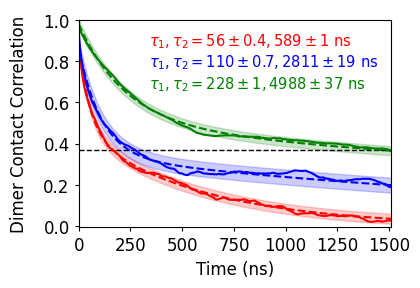

In [359]:
fig, ax = plt.subplots(1, 1, figsize=(4.3, 3))

ax.axhline(y=1/np.exp(1),
           linestyle='--',
           color='black',
           linewidth=1,
           #label='1/e',
          )

colors = ['red', 'blue', 'green']
labels = ['APO', 'EPI-002', '1aa']

for i, (ac, color, label) in enumerate(zip(acfs, colors, labels)):
    yhat, y_err = multi_exp(
        0.24 * np.arange(8000),
        *fits[i]['popt'],
        pcov=fits[i]['pcov'],
        s2=fits[i]['ss_res'] / fits[i]['dof'],
        prediction_variance=True,
        return_error=True,
    )

    # fitted curve + confidence band
    lineplot1D(
        yhat,
        0.24 * np.arange(8000),
        y1=yhat - 2 * y_err,
        y2=yhat + 2 * y_err,
        fill_alpha=.2,
        ax=ax,
        label_stride=250,
        color=color,
        fill_color=color,
        ls='--'
    )

    # empirical ACF (dashed)
    lineplot1D(
        ac[0][:8000],
        0.24 * np.arange(8000),
        fill_alpha=1,
        ax=ax,
        label_stride=241,
        color=color,
        ls='-',
        ylabel_rotation=90,
        label = label,
        
    )

ax.set_xlim(0, 1510)

# ---------- annotation block (top-right) ----------
x_text = 0.985
y_top = 1.05
line_spacing = 0.105

# leave blank space for manual equation
ax.text(
    x_text, y_top, " ",  # intentional blank
    color='black',
    fontsize=11,
    transform=ax.transAxes,
    ha='right', va='top'
)

# --- improved numeric formatting ---
def fmt_value(x: float) -> str:
    """Format numeric value:
    - ≥1  → integer
    - <1  → one significant figure
    """
    if x >= 1.0:
        return str(int(np.round(x)))
    # compute one significant figure manually
    if x == 0:
        return "0"
    exp = int(np.floor(np.log10(abs(x))))
    rounded = round(x, -exp)  # round to 1 sig fig
    # format cleanly, no trailing zeros
    return np.format_float_positional(rounded, trim='-')

#τ lines
for i, (label, color, fit) in enumerate(zip(labels, colors, fits)):
    popt = np.array(fit['popt'], dtype=float)
    perr = np.sqrt(np.diag(fit['pcov']))

    taus = popt[1::2]
    tau_errs = perr[1::2]

    tau_syms = ", ".join([rf"\tau_{{{j+1}}}" for j in range(len(taus))])

    tau_vals = []
    for tau, err in zip(taus, tau_errs):
        tau_disp = fmt_value(float(tau))
        err_disp = fmt_value(float(err))
        tau_vals.append(rf"{tau_disp}\pm{err_disp}")
    tau_vals = ", ".join(tau_vals)

    #text_line = rf"{label}: ${tau_syms} = {tau_vals}\ \mathrm{{ns}}$"
    text_line = rf"${tau_syms} = {tau_vals}\ \mathrm{{ns}}$"


    ax.text(
        x_text-.76,
        y_top - (i + 1) * line_spacing,
        text_line,
        color=color,
        fontsize=10.5,
        transform=ax.transAxes,
        ha='left', va='top',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.65, pad=1.5)
    )
ax.set_ylabel('Dimer Contact Correlation', )
ax.set_xlabel('Time (ns)')
plt.tight_layout()
ax.set_xticks([0, 250, 500, 750, 1000, 1250, 1500], [0, 250, 500, 750, 1000, 1250, 1500])
#ax.legend(bbox_to_anchor=[1,1])
fig.savefig('./binding_curves.png', dpi=1000, bbox_inches='tight')

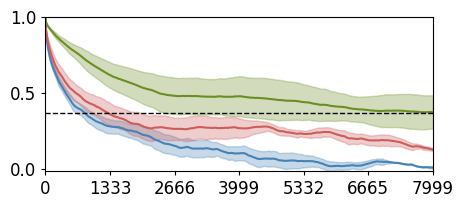

In [168]:
colors = ['steelblue', 'indianred', 'olivedrab']
labels = ['APO', 'EPI-002', '1aa']
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
for ac, color, label in zip(acfs, colors, labels):
    lineplot1D(ac[0],
               y1=ac[1][0],
               y2=ac[1][1],
               label_stride=1000,
               fill_alpha=0.3,
               figsize=(4, 2),
               color=color, 
               ax=ax, fill_color=color
               
              ) 

ax.axhline(y=1/np.exp(1),
                linestyle='--',
                color='black',
                linewidth=1,
                label='1/e',
               )
#ax.set_xscale('log')
#ax.set_yscale('log')